# Importing required Libraries

In [1]:
# importing required liberaries
import requests
import numpy as np
import cv2
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
import itertools
from IPython.display import clear_output


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import copy

In [3]:
# this gives a track of the latest frame displayed by open cv
var_p1 = [] 
image_with_filter = [] 

# setting up our highper parameters for displaying facial key points if needed
color = (0, 0, 255) 
thickness = 2
radius = 2

# Loading  architechture and weights of our Trained model

We are loading the architecture of our pretrained model from .json file
Loading weights from the .hdf5 file 

In [4]:
with open('KeyPointDetector.json','r') as json_file:

    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')

Getting the names of the facial key_points

In [6]:
facialpoints_df = pd.read_csv('training.csv')
columns = facialpoints_df.columns[:-1]
del facialpoints_df
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [8]:
len(columns)

30

Using Haarcascade classifier to detect the frountal face

In [9]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# K Means clustering

Since, we have the hardware restrictions.Therefore the model is trained on image shape of (96 X 96 X 1). The key points predicted are also on the image of size (96 X 96 X 1). In order to get keypoints on higher image dimensions we use the Kmeans clustering Furthur detailed visuals are given at the end

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=1,
    n_init=1,
    max_iter=1,
    random_state=42
    )

Here we will be calculating the key points on much higher image dimensions

In [20]:
def enlarged_point(df_predict_copy,frame_width,frame_hight):
    
#       we will take all the points
        df_predict_copy = df_predict_copy.astype(np.int16)
        df_predict_copy = np.array(df_predict_copy)
        key_points = []
        for i in range(1,31,2):
            
#           creating a black frame of the same size as our model inputs 
            b2_frame = np.zeros((96,96,1))
            
#           marking the key_points on the black frame
    
            b2_frame[df_predict_copy[0,i],df_predict_copy[0,i-1]] = 255
            x_y = []
            
#           enlarging the black frame to the original size of the face 
#           as we enlarge the frame the points we marked become a clustur of points and we want the center of that cluster

            b2_frame = cv2.resize(b2_frame,(og_width,og_hight))
    
            hx ,hy = b2_frame.shape
            for i in range(hx):
                for j in range(hy):
                    if b2_frame[i,j] :

                        x_y.append([i,j])
            x_y = np.array(x_y)
            
#           here we use KMeans to fid the centroid of the cluster.
#           Since I am locating one cluster or one key point on image at a time, I used max_iters,n_init,n_clusters = 1

            kmeans.fit(x_y[:,:2])
            
#            getting the coordinates of key_points on the original image

            key_points.append(kmeans.cluster_centers_)

        return key_points

These are the list of keypoints which we have on our enlarged image or the original image

In [ ]:
# 0 : left_eye_center
# 1 : right_eye_center
# 2 : left_eye_inner_corner
# 3 : left_eye_outer_corner
# 4 : right_eye_inner_corner
# 5 : right_eye_outer_corner
# 6 : left_eyebrow_inner_end
# 7 : left_eyebrow_outer_end
# 8 : right_eyebrow_inner_end
# 9 : right_eyebrow_outer_end
# 10 : nose_tip
# 11 : mouth_left_corner
# 12 : mouth_right_corner
# 13 : mouth_center_top_lip
# 14 : mouth_center_bottom_lip

In [21]:
check_coordinates = []

In [32]:
# we use the ip webcam for using mobile camera for displaing on our pc 
while True:

    # getting the address for our mobile camera
    
    # here instead of 192.168.44.1:8080 you write your own ip given by ip webcam for your android
    image = requests.get("http://192.168.43.1:8080/shot.jpg") 
    
    # conveerting into numpy array
    video = np.array(bytearray(image.content),dtype = np.uint8)
    
    # decoding our numpy array
    render = cv2.imdecode(video,-1)
    
    #cv2.imshow('frame',render)
    
    # loading our haar cascade file 
    
    
    # converting into gray scale from rgb
    gray = cv2.cvtColor(render, cv2.COLOR_BGR2GRAY)
    
    # detecting faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  
    # making a rectangle box on the detected faces
    for (x,y,w,h) in faces:
        
#       getting the image of the face 
        var_p1 = render[ y:y+h ,x:x+w,1]
#       resizing  the image to the shape of model inputs 
    
        og_width,og_hight = var_p1.shape
        image_sample = cv2.resize(var_p1,(96,96))
        img = array_to_img(image_sample.reshape((96,96,1)))
        arr = img_to_array(img)
        
        background_image = arr
        arr = arr/255
        arr = arr.reshape((1,96,96,1))
        
#       prdecting the key points on the image of the face        
        df_predict = model.predict(arr)
#         print('model_predicted')
        df_enlarged_points = []
        df_sample = df_predict
#         key_points = np.zeros((15,2))
        
#       getting the key points on the original size of the image of the face         
        try: 
            key_points = enlarged_point(df_sample,og_width,og_hight)
            key_points = np.array(key_points)
            key_points = np.reshape(key_points,(15,2))
            key_points = key_points.astype(np.int16)
        except:
            continue
        
        

#       getting the coordinates of all key points on the frame displayed by open cv     
        try:
            true_coordinates = []
            for i in range(15):
                center_coordinates = (x+key_points[i,1],y+key_points[i,0])
                
                true_coordinates.append(center_coordinates)
                
                render = cv2.circle(render, center_coordinates, radius, color, thickness)  
        except:
            continue
        
         
            
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = render[y:y+h, x:x+w]
        
    # displaying the video frame with detected faces
    cv2.imshow('frame',render)
    
    # setting our terminating commands
    if (cv2.waitKey(1)==ord('q')):
        cv2.destroyAllWindows()
        break

# Grayscale visualization 

Here is a grayscale image of the detected face and the key points on it

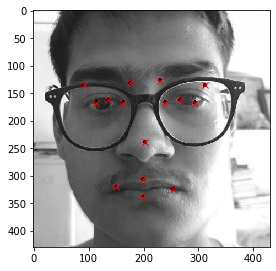

In [33]:
fig = plt.figure(figsize=(20,20))

for i in range(1):
    ax = fig.add_subplot(4,2,i+1)

    plt.imshow(var_p1,cmap='gray')

    for j in range(15):
        plt.plot(key_points[j,1], key_points[j , 0],'rx')

These are the values of x's and y's of the key points predicted by model on image(96 x 96 x 1)

In [34]:
df_sample

array([[59.095245, 36.669262, 30.930792, 36.85968 , 53.955254, 37.58633 ,
        65.24699 , 37.696983, 36.702023, 37.525063, 25.007065, 37.99825 ,
        51.458405, 28.861706, 69.9388  , 30.31036 , 39.728165, 29.370756,
        20.701668, 30.880945, 45.150238, 53.233086, 56.51429 , 72.1907  ,
        33.095192, 71.72031 , 44.33285 , 68.95944 , 44.409348, 75.35056 ]],
      dtype=float32)

# generating the points on small image 

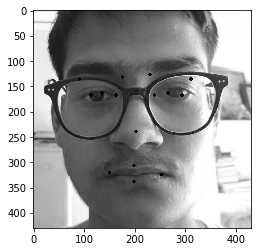

In [35]:
# This is the image of face having the original size 
import matplotlib.pyplot as plt
plt.imshow(var_p1,cmap='gray')

Resizing the image

In [36]:
og_width,og_hight = var_p1.shape
image_sample = cv2.resize(var_p1,(96,96))
img = array_to_img(image_sample.reshape((96,96,1)))
arr = img_to_array(img)

background_image1 = arr


arr = arr/255
arr = arr.reshape((1,96,96,1))

Now, This image is perfect to feed into our model

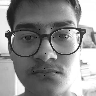

In [37]:
img

In [38]:
df_predict = model.predict(arr)

Here is a dataframe for the predicted values of the key_points

In [39]:
df_predict = pd.DataFrame(df_predict,columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,60.712852,37.312832,29.649933,37.336105,54.992752,38.102123,67.435036,38.428612,35.871277,38.037861,...,45.234421,53.039864,57.513866,72.771362,31.673985,72.377815,44.23291,69.138763,44.202869,76.323143


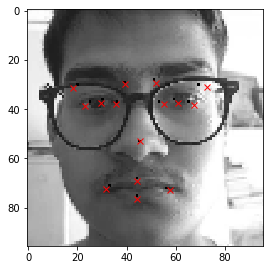

In [40]:
fig = plt.figure(figsize=(20,20))

# ploting the key_points on the resized image of face
for i in range(1):
    ax = fig.add_subplot(4,2,i+1)

    plt.imshow(arr.squeeze(),cmap='gray')

    for j in range(1,31,2):
        plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j],'rx')

# Creating a black plane for locating points

In [41]:
b_frame = np.zeros((96,96,1))

In [42]:
b_frame.shape

(96, 96, 1)

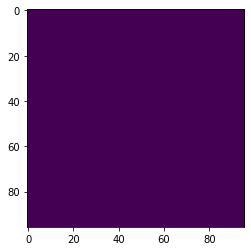

In [43]:
plt.imshow(b_frame.reshape((96,96)))

In [44]:
# ploting the key_points on the black frame 

df_predict = df_predict.astype(np.int16)
for j in range(1,31,2):
    b_frame[df_predict.loc[0][j],df_predict.loc[0][j-1]] = 255

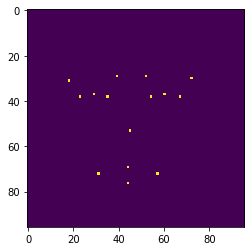

In [45]:
plt.imshow(b_frame.reshape((96,96)))

resizing the frame to the original size of the image of face

After enlarging the points we ploted will be zoomed and became a cluster of points

In [46]:
b_frame = cv2.resize(b_frame,(og_width,og_hight))

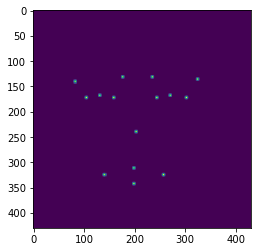

In [47]:
plt.imshow(b_frame)

In [48]:
# getting all the points with non zero pixel value

x_y = []
hx ,hy = b_frame.shape
for i in range(hx):
    for j in range(hy):
        if b_frame[i,j] :
            
            x_y.append([i,j,b_frame[i,j]])
            

In [49]:
x_y = np.array(x_y)

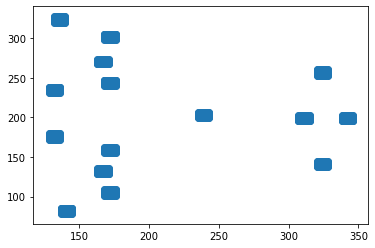

In [50]:
# Plotting the cluster of points

plt.scatter(x_y[:,0],x_y[:,1])

In [51]:
x_y[i,0]

168.0

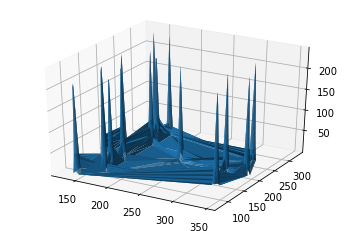

In [52]:
# The peaks in the graph are the points in which we are interested.These are the centroids of each clusters

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_y[:,0], x_y[:,1],x_y[:,2], linewidth=0, antialiased=True)
plt.show()

In [53]:
np.array(x_y).shape

(1197, 3)

In [54]:
np.max(b_frame)

243.24296917252835

# using Kmeans clustering for locating the centers of points in enlarged image

In [55]:
# Here I have used the parameters higher than given above because here i am locating all centers of clusters at once
kmeans = KMeans(
            init="random",
            n_clusters=15,
            n_init=500,
            max_iter=1000,
            random_state=42
            )

In [56]:
kmeans.fit(x_y[:,:2])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=15, n_init=500, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Getting all the key_points on original image at once 

In [57]:
key_points = kmeans.cluster_centers_

In [58]:
key_points

array([[167. , 132. ],
       [239. , 203. ],
       [167. , 270.5],
       [324. , 141. ],
       [132. , 176. ],
       [342. , 199. ],
       [141. ,  82. ],
       [132. , 235. ],
       [172. , 105. ],
       [311. , 199. ],
       [172. , 244. ],
       [324. , 257. ],
       [172. , 302. ],
       [136. , 324. ],
       [172. , 158.5]])

In [59]:
key_points = key_points.astype(np.int16)

In [60]:
key_points[1,1]

203

Here The red points are the key_points that we obtained by using Kmeans once and finding all
And the black points are the points obtained by one-by-one strategy and finding one key_point at a time by Kmeans

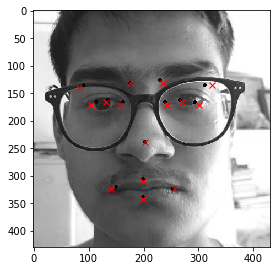

In [61]:
fig = plt.figure(figsize=(20,20))

for i in range(1):
    ax = fig.add_subplot(4,2,i+1)

    plt.imshow(var_p1,cmap='gray')

    for j in range(15):
        plt.plot(key_points[j,1], key_points[j , 0],'rx')